In [ ]:
import os
from TFBS_negatives.data import DataModule
from TFBS_negatives.models import TFmodel
import pytorch_lightning as pl
ckpt_files = [f for f in os.listdir('/data/home/natant/Negatives/Runs/full_run_2') if f.endswith('.ckpt')]
print(ckpt_files)

/data/home/natant/anaconda3/envs/Negs/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['GM12878_Mxi1_(AF4185)_dinucl_sampled_CV-0_20250523_18:59_epoch=13_val_loss=0.49_AUROC=0.84.ckpt', 'HepG2_FOXA1_(SC-101058)_dinucl_shuffled_CV-3_20250524_18:34_epoch=13_val_loss=0.40_AUROC=0.90.ckpt', 'GM12878_Znf143_(16618-1-AP)_dinucl_shuffled_CV-2_20250524_02:14_epoch=13_val_loss=0.50_AUROC=0.90.ckpt', 'K562_YY1_(SC-281)_dinucl_shuffled_CV-0_20250526_04:44_epoch=19_val_loss=0.70_AUROC=0.75.ckpt', 'GM12878_STAT5A_(SC-74442)_neighbors_CV-3_20250524_06:03_epoch=18_val_loss=0.69_AUROC=0.60.ckpt', 'K562_ETS1_dinucl_sampled_CV-1_20250526_20:47_epoch=28_val_loss=0.64_AUROC=0.81.ckpt', 'GM12878_ETS1_dinucl_sampled_CV-2_20250524_10:03_epoch=27_val_loss=0.50_AUROC=0.89.ckpt', 'MCF-7_ZNF217_dinucl_sampled_CV-3_20250523_15:19_epoch=13_val_loss=0.64_AUROC=0.69.ckpt', 'GM12878_RFX5_(200-401-194)_dinucl_shuffled_CV-1_20250523_23:11_epoch=35_val_loss=0.64_AUROC=0.69.ckpt', 'GM12878_ELF1_(SC-631)_neighbors_CV-2_20250524_00:04_epoch=29_val_loss=0.67_AUROC=0.70.ckpt', 'GM12878_ELK1_(1277-1)_dinucl_sh

: 

In [ ]:
conv_library = {
    'dinucl_sampled': 'dinucl-sampled',
    'dinucl_shuffled': 'dinucl-shuffled',
    'shuffled': 'shuffled',
}
neg_mode_to_check = 'shuffled'
cell_type_to_check = 'A549'
cross_val_set = 'CV-0'


selected_files = []
TF_list = []
target_files = {}
for file_name in ckpt_files:
    file_name_temp = file_name.split('.ckpt')[0]
    for key, value in conv_library.items():
        file_name_temp = file_name_temp.replace(key, value)
    neg_mode = file_name_temp.split('_')[-8]
    celltype = file_name_temp.split('_')[0]
    CV = file_name_temp.split('_')[-7]
    TF = '_'.join(file_name_temp.split("_")[1:-8])
    if neg_mode == conv_library[neg_mode_to_check] and celltype == cell_type_to_check and CV == cross_val_set:
        selected_files.append(file_name)
        if TF not in TF_list:
            target_files[TF] = file_name
            TF_list.append(TF)

data_file = f"/data/home/natant/Negatives/Data/Encode690/ENCODE_hg38_subset_101bp_celltypes_ATAC_H5_all_chr/{cell_type_to_check}.h5t"
results_dict_AUROC = {}
results_dict_AUROC_HQ = {}

for target_TF in TF_list:
    file_name = target_files[target_TF]
    print(f"Processing file: {file_name}")
    file_name_temp = file_name.split('.ckpt')[0]
    for key, value in conv_library.items():
        file_name_temp = file_name_temp.replace(key, value)
    results_dict_AUROC[target_TF] = []
    results_dict_AUROC_HQ[target_TF] = []
    file = '/data/home/natant/Negatives/Runs/full_run_2/' + file_name
    
    
    for TF in TF_list:
        best_model = TFmodel.load_from_checkpoint(file)
        trainer = pl.Trainer(
                accelerator="gpu",
                devices=[1]
            )
        Dmod = DataModule(data_file, TF=TF, batch_size=256, neg_mode=neg_mode_to_check, cross_val_set=int(cross_val_set.split('-')[1]))
        test_out = trainer.test(best_model, datamodule=Dmod)
        results_dict_AUROC[target_TF].append(test_out[0]['test_AUROC'])
        results_dict_AUROC_HQ[target_TF].append(test_out[0]['test_AUROC_HQ'])
        print(f"Model TF: {target_TF}, Test TF: {TF}, AUROC: {test_out[0]['test_AUROC']}, AUROC_HQ: {test_out[0]['test_AUROC_HQ']}")

shuffled_results_dict_AUROC = results_dict_AUROC
shuffled_results_dict_AUROC_HQ = results_dict_AUROC_HQ


Processing file: A549_ETS1_shuffled_CV-0_20250527_11:32_epoch=31_val_loss=0.45_AUROC=0.88.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/data/home/natant/anaconda3/envs/Negs/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off pre

Testing DataLoader 0:   0%|          | 0/20 [00:00<?, ?it/s]

/data/home/natant/Negatives/TFBS_negatives/TFBS_negatives/models.py:367: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_DNA = self.DNA_branch(self.embedding(torch.tensor(x_DNA_in, dtype=torch.int)).permute(0, 2, 1))


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 133.26it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8500854969024658       0.8500854969024658
      test_AUROC_HQ         0.43095892667770386      0.43095892667770386
      test_Accuracy          0.777866542339325        0.777866542339325
    test_Accuracy_HQ        0.19142305850982666      0.19142305850982666
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Model TF: ETS1, Test TF: ETS1, AUROC: 0.8500854969024658, AUROC_HQ: 0.43095892667770386


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 139.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8701272010803223       0.8701272010803223
      test_AUROC_HQ          0.449140727519989        0.449140727519989
      test_Accuracy         0.7929244041442871       0.7929244041442871
    test_Accuracy_HQ        0.19488081336021423      0.19488081336021423
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model TF: ETS1, Test TF: ATF3, AUROC: 0.8701272010803223, AUROC_HQ: 0.449140727519989


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 530/530 [00:03<00:00, 141.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8989052772521973       0.8989052772521973
      test_AUROC_HQ         0.47423556447029114      0.47423556447029114
      test_Accuracy         0.8185999989509583       0.8185999989509583
    test_Accuracy_HQ        0.23928378522396088      0.23928378522396088
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Model TF: ETS1, Test TF: FOSL2, AUROC: 0.8989052772521973, AUROC_HQ: 0.47423556447029114


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 131.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8699886202812195       0.8699886202812195
      test_AUROC_HQ         0.4567440152168274       0.4567440152168274
      test_Accuracy         0.7897107601165771       0.7897107601165771
    test_Accuracy_HQ        0.1906498372554779       0.1906498372554779
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model TF: ETS1, Test TF: SIX5, AUROC: 0.8699886202812195, AUROC_HQ: 0.4567440152168274


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 133.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8499050140380859       0.8499050140380859
      test_AUROC_HQ         0.39616426825523376      0.39616426825523376
      test_Accuracy         0.7700361013412476       0.7700361013412476
    test_Accuracy_HQ        0.18707333505153656      0.18707333505153656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model TF: ETS1, Test TF: BHLHE40, AUROC: 0.8499050140380859, AUROC_HQ: 0.39616426825523376


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 518/518 [00:03<00:00, 152.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8902090191841125       0.8902090191841125
      test_AUROC_HQ         0.46815964579582214      0.46815964579582214
      test_Accuracy         0.8115676641464233       0.8115676641464233
    test_Accuracy_HQ        0.19859318435192108      0.19859318435192108
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model TF: ETS1, Test TF: USF-1, AUROC: 0.8902090191841125, AUROC_HQ: 0.46815964579582214


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 136.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8903796672821045       0.8903796672821045
      test_AUROC_HQ         0.5136198997497559       0.5136198997497559
      test_Accuracy          0.807722806930542        0.807722806930542
    test_Accuracy_HQ        0.19959159195423126      0.19959159195423126
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model TF: ETS1, Test TF: ELF1_(SC-631), AUROC: 0.8903796672821045, AUROC_HQ: 0.5136198997497559


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 127.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8471361398696899       0.8471361398696899
      test_AUROC_HQ         0.43266409635543823      0.43266409635543823
      test_Accuracy         0.7682371735572815       0.7682371735572815
    test_Accuracy_HQ        0.21007908880710602      0.21007908880710602
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model TF: ETS1, Test TF: CREB1_(SC-240), AUROC: 0.8471361398696899, AUROC_HQ: 0.43266409635543823


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 529/529 [00:03<00:00, 141.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.88596510887146         0.88596510887146
      test_AUROC_HQ         0.4691718816757202       0.4691718816757202
      test_Accuracy         0.8072354197502136       0.8072354197502136
    test_Accuracy_HQ        0.22340025007724762      0.22340025007724762
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model TF: ETS1, Test TF: TCF12, AUROC: 0.88596510887146, AUROC_HQ: 0.4691718816757202


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 121.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.864600658416748        0.864600658416748
      test_AUROC_HQ         0.43698281049728394      0.43698281049728394
      test_Accuracy         0.7870887517929077       0.7870887517929077
    test_Accuracy_HQ        0.19496311247348785      0.19496311247348785
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model TF: ETS1, Test TF: ZBTB33, AUROC: 0.864600658416748, AUROC_HQ: 0.43698281049728394


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 133.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8708317875862122       0.8708317875862122
      test_AUROC_HQ         0.46068882942199707      0.46068882942199707
      test_Accuracy         0.7881168127059937       0.7881168127059937
    test_Accuracy_HQ        0.20159825682640076      0.20159825682640076
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model TF: ETS1, Test TF: YY1_(SC-281), AUROC: 0.8708317875862122, AUROC_HQ: 0.46068882942199707


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 144.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8490272760391235       0.8490272760391235
      test_AUROC_HQ         0.42163074016571045      0.42163074016571045
      test_Accuracy         0.7726141810417175       0.7726141810417175
    test_Accuracy_HQ        0.19981524348258972      0.19981524348258972
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model TF: ETS1, Test TF: Max, AUROC: 0.8490272760391235, AUROC_HQ: 0.42163074016571045


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:03<00:00, 135.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8802391886711121       0.8802391886711121
      test_AUROC_HQ         0.4486510455608368       0.4486510455608368
      test_Accuracy         0.7994707226753235       0.7994707226753235
    test_Accuracy_HQ        0.19663342833518982      0.19663342833518982
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model TF: ETS1, Test TF: FOXA1_(SC-101058), AUROC: 0.8802391886711121, AUROC_HQ: 0.4486510455608368


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:03<00:00, 143.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.9069746732711792       0.9069746732711792
      test_AUROC_HQ         0.5013393759727478       0.5013393759727478
      test_Accuracy         0.8264958262443542       0.8264958262443542
    test_Accuracy_HQ        0.2727794647216797       0.2727794647216797
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model TF: ETS1, Test TF: CTCF, AUROC: 0.9069746732711792, AUROC_HQ: 0.5013393759727478
Processing file: A549_ATF3_shuffled_CV-0_20250527_10:33_epoch=43_val_loss=0.50_AUROC=0.92.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 140.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7773771286010742       0.7773771286010742
      test_AUROC_HQ         0.25084567070007324      0.25084567070007324
      test_Accuracy         0.7071514129638672       0.7071514129638672
    test_Accuracy_HQ        0.11453323811292648      0.11453323811292648
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model TF: ATF3, Test TF: ETS1, AUROC: 0.7773771286010742, AUROC_HQ: 0.25084567070007324


In [94]:
selected_files

['A549_ETS1_shuffled_CV-0_20250527_11:32_epoch=31_val_loss=0.45_AUROC=0.88.ckpt',
 'A549_ATF3_shuffled_CV-0_20250527_10:33_epoch=43_val_loss=0.50_AUROC=0.92.ckpt',
 'A549_FOSL2_shuffled_CV-0_20250527_08:45_epoch=29_val_loss=0.34_AUROC=0.97.ckpt',
 'A549_SIX5_shuffled_CV-0_20250527_12:02_epoch=48_val_loss=0.62_AUROC=0.86.ckpt',
 'A549_BHLHE40_shuffled_CV-0_20250527_09:54_epoch=51_val_loss=0.49_AUROC=0.91.ckpt',
 'A549_USF-1_shuffled_CV-0_20250527_11:01_epoch=46_val_loss=0.33_AUROC=0.94.ckpt',
 'A549_ELF1_(SC-631)_shuffled_CV-0_20250527_09:20_epoch=35_val_loss=0.54_AUROC=0.93.ckpt',
 'A549_CREB1_(SC-240)_shuffled_CV-0_20250527_07:17_epoch=30_val_loss=0.44_AUROC=0.90.ckpt',
 'A549_TCF12_shuffled_CV-0_20250527_08:15_epoch=34_val_loss=0.28_AUROC=0.95.ckpt',
 'A549_ZBTB33_shuffled_CV-0_20250527_12:28_epoch=25_val_loss=0.51_AUROC=0.89.ckpt',
 'A549_YY1_(SC-281)_shuffled_CV-0_20250527_06:47_epoch=22_val_loss=0.43_AUROC=0.91.ckpt',
 'A549_Max_shuffled_CV-0_20250527_07:45_epoch=33_val_loss=0.48_

In [90]:
import pandas as pd

# Create DataFrame from shuffled_results_dict_AUROC, using TF_list as columns
df_shuffled_auroc = pd.DataFrame.from_dict(shuffled_results_dict_AUROC, orient='index', columns=TF_list)
df_shuffled_auroc = df_shuffled_auroc.loc[TF_list]
TF_order = df_shuffled_auroc.mean(axis=1).sort_values(ascending=False).index.to_list()

In [ ]:
df_shuffled_auroc_HQ = pd.DataFrame.from_dict(shuffled_results_dict_AUROC_HQ, orient='index', columns=TF_list)
df_shuffled_auroc_HQ = df_shuffled_auroc_HQ.loc[TF_list]


In [99]:
df_shuffled_auroc_HQ

,TCF12,CREB1_(SC-240),USF-1,FOSL2,ZBTB33,ATF3,ETS1,YY1_(SC-281),CTCF,ELF1_(SC-631),Max,SIX5,FOXA1_(SC-101058),BHLHE40
TCF12,0.477114,0.487043,0.425243,0.280968,0.434872,0.371970,0.437948,0.444477,0.429159,0.508803,0.433191,0.441801,0.473864,0.460235
CREB1_(SC-240),0.494292,0.495881,0.486472,0.424970,0.498333,0.451690,0.491550,0.495174,0.484136,0.500838,0.488576,0.492198,0.495728,0.498447
USF-1,0.436720,0.439045,0.406920,0.279067,0.414007,0.354886,0.427848,0.418790,0.408286,0.455854,0.408981,0.415561,0.442658,0.431625
FOSL2,0.519160,0.527821,0.456672,0.297948,0.472555,0.392608,0.460266,0.475304,0.457486,0.553431,0.462379,0.471594,0.510676,0.493788
ZBTB33,0.465694,0.469528,0.448101,0.369227,0.451770,0.414423,0.455244,0.454623,0.446365,0.479774,0.451138,0.453366,0.465160,0.462806
ATF3,0.465820,0.476603,0.401375,0.250846,0.412899,0.355436,0.421458,0.423778,0.405759,0.501846,0.410430,0.421061,0.462452,0.445026
ETS1,0.458968,0.463233,0.457800,0.430959,0.460790,0.440961,0.467603,0.462529,0.457306,0.463987,0.460821,0.460835,0.460346,0.467252
YY1_(SC-281),0.440365,0.447393,0.438727,0.374548,0.433182,0.408746,0.459721,0.439367,0.438621,0.452536,0.443363,0.437727,0.442397,0.444406
CTCF,0.333247,0.335198,0.348496,0.255088,0.346101,0.316411,0.465814,0.349256,0.348349,0.343903,0.349048,0.347012,0.342307,0.343513
ELF1_(SC-631),0.476289,0.484906,0.458693,0.427870,0.470798,0.449101,0.472056,0.474058,0.460276,0.488875,0.466308,0.471812,0.476213,0.490754


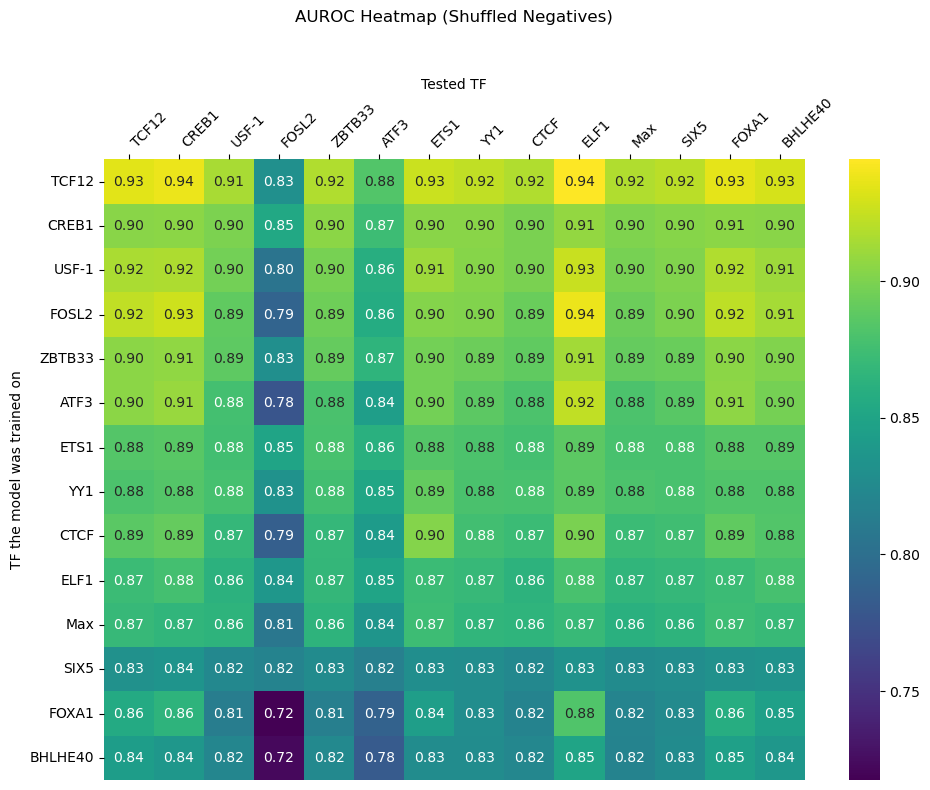

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

# Shorten TF labels by taking only the part before the first "_"
short_labels = [label.split("_")[0] for label in df_shuffled_auroc.columns]

# Reorder the DataFrame and short_labels according to TF_order
df_shuffled_auroc_ordered = df_shuffled_auroc.loc[TF_order, TF_order]
short_labels_ordered = [label.split("_")[0] for label in TF_order]

plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_shuffled_auroc_ordered, annot=True, cmap="viridis", fmt=".2f",
                 xticklabels=short_labels_ordered, yticklabels=short_labels_ordered)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xticks(rotation=45, ha='left')
plt.title("AUROC Heatmap (Shuffled Negatives)", pad=40)
plt.ylabel("TF the model was trained on")
plt.xlabel("Tested TF")
plt.tight_layout()
plt.show()

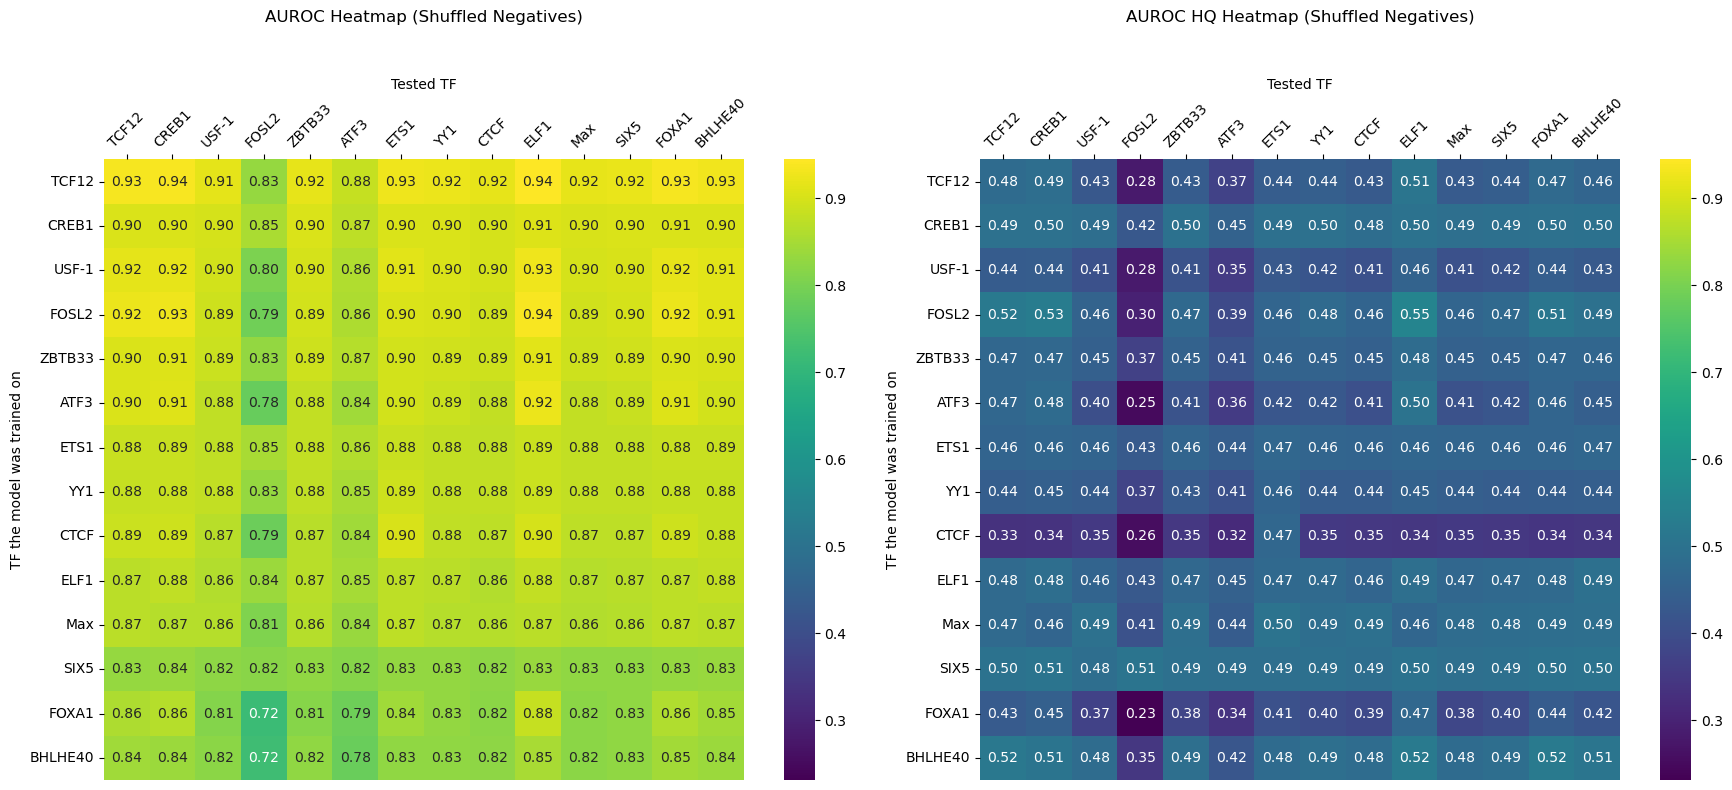

In [92]:
# Create DataFrame for HQ results using the same TF_list and ordering as the normal results
df_shuffled_auroc_HQ = pd.DataFrame.from_dict(shuffled_results_dict_AUROC_HQ, orient='index', columns=TF_list)
df_shuffled_auroc_HQ = df_shuffled_auroc_HQ.loc[TF_order, TF_order]

# Find global min and max for both heatmaps
vmin = min(df_shuffled_auroc_ordered.min().min(), df_shuffled_auroc_HQ.min().min())
vmax = max(df_shuffled_auroc_ordered.max().max(), df_shuffled_auroc_HQ.max().max())

# Plot side by side with the same color scale
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

short_labels_ordered = [label.split("_")[0] for label in TF_order]

# Normal AUROC heatmap
sns.heatmap(df_shuffled_auroc_ordered, annot=True, cmap="viridis", fmt=".2f",
            xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, ax=axes[0],
            vmin=vmin, vmax=vmax)
axes[0].xaxis.set_ticks_position('top')
axes[0].xaxis.set_label_position('top')
axes[0].set_title("AUROC Heatmap (Shuffled Negatives)", pad=40)
axes[0].set_ylabel("TF the model was trained on")
axes[0].set_xlabel("Tested TF")
axes[0].tick_params(axis='x', rotation=45, labelrotation=45)

# HQ AUROC heatmap
sns.heatmap(df_shuffled_auroc_HQ, annot=True, cmap="viridis", fmt=".2f",
            xticklabels=short_labels_ordered, yticklabels=short_labels_ordered, ax=axes[1],
            vmin=vmin, vmax=vmax)
axes[1].xaxis.set_ticks_position('top')
axes[1].xaxis.set_label_position('top')
axes[1].set_title("AUROC HQ Heatmap (Shuffled Negatives)", pad=40)
axes[1].set_ylabel("TF the model was trained on")
axes[1].set_xlabel("Tested TF")
axes[1].tick_params(axis='x', rotation=45, labelrotation=45)

plt.tight_layout()
plt.show()

In [69]:
conv_library = {
    'dinucl_sampled': 'dinucl-sampled',
    'dinucl_shuffled': 'dinucl-shuffled',
    'shuffled': 'shuffled'
}
neg_mode_to_check = 'dinucl_sampled' #! fill in 
cell_type_to_check = 'A549'
cross_val_set = 'CV-0'


selected_files = []
TF_list = []
for file_name in ckpt_files:
    file_name_temp = file_name.split('.ckpt')[0]
    for key, value in conv_library.items():
        file_name_temp = file_name_temp.replace(key, value)
    neg_mode = file_name_temp.split('_')[-8]
    celltype = file_name_temp.split('_')[0]
    CV = file_name_temp.split('_')[-7]
    TF = '_'.join(file_name_temp.split("_")[1:-8])
    if neg_mode == conv_library[neg_mode_to_check] and celltype == cell_type_to_check and CV == cross_val_set:
        selected_files.append(file_name)
        if TF not in TF_list:
            TF_list.append(TF)

data_file = f"/data/home/natant/Negatives/Data/Encode690/ENCODE_hg38_subset_101bp_celltypes_ATAC_H5_all_chr/{cell_type_to_check}.h5t"
results_dict_AUROC = {}
results_dict_AUROC_HQ = {}

for file_name in selected_files:
    file_name_temp = file_name.split('.ckpt')[0]
    for key, value in conv_library.items():
        file_name_temp = file_name_temp.replace(key, value)
    target_TF = '_'.join(file_name_temp.split("_")[1:-8])
    results_dict_AUROC[target_TF] = []
    results_dict_AUROC_HQ[target_TF] = []
    file = '/data/home/natant/Negatives/Runs/full_run_2/' + file_name

    best_model = TFmodel.load_from_checkpoint(file)
    trainer = pl.Trainer(
            accelerator="gpu",
            devices=[1]
        )
    
    for TF in TF_list:
        Dmod = DataModule(data_file, TF=TF, batch_size=256, neg_mode=neg_mode_to_check, cross_val_set=int(cross_val_set.split('-')[1]))
        test_out = trainer.test(best_model, datamodule=Dmod)
        results_dict_AUROC[target_TF].append(test_out[0]['test_AUROC'])
        results_dict_AUROC_HQ[target_TF].append(test_out[0]['test_AUROC_HQ'])

dinucl_sampled_results_dict_AUROC = results_dict_AUROC
dinucl_sampled_results_dict_AUROC_HQ = results_dict_AUROC_HQ


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 530/530 [00:03<00:00, 139.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.9108034372329712       0.9108034372329712
      test_AUROC_HQ         0.8762513995170593       0.8762513995170593
      test_Accuracy         0.8395093679428101       0.8395093679428101
    test_Accuracy_HQ        0.8407846093177795       0.8407846093177795
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 133.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8851664662361145       0.8851664662361145
      test_AUROC_HQ         0.8358976244926453       0.8358976244926453
      test_Accuracy         0.8033289313316345       0.8033289313316345
    test_Accuracy_HQ        0.8256962895393372       0.8256962895393372
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 134.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8599468469619751       0.8599468469619751
      test_AUROC_HQ         0.7986211180686951       0.7986211180686951
      test_Accuracy         0.7606135606765747       0.7606135606765747
    test_Accuracy_HQ         0.818497359752655        0.818497359752655
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 133.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8450422286987305       0.8450422286987305
      test_AUROC_HQ         0.7733234763145447       0.7733234763145447
      test_Accuracy         0.7158817648887634       0.7158817648887634
    test_Accuracy_HQ        0.8140493631362915       0.8140493631362915
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 529/529 [00:03<00:00, 140.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8259974122047424       0.8259974122047424
      test_AUROC_HQ         0.7510601282119751       0.7510601282119751
      test_Accuracy         0.6925158500671387       0.6925158500671387
    test_Accuracy_HQ        0.8108168840408325       0.8108168840408325
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:03<00:00, 138.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8144538402557373       0.8144538402557373
      test_AUROC_HQ         0.7387248277664185       0.7387248277664185
      test_Accuracy         0.6812441349029541       0.6812441349029541
    test_Accuracy_HQ        0.8096843361854553       0.8096843361854553
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 134.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.813888669013977        0.813888669013977
      test_AUROC_HQ         0.7370736598968506       0.7370736598968506
      test_Accuracy         0.6796180605888367       0.6796180605888367
    test_Accuracy_HQ        0.8101258277893066       0.8101258277893066
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 132.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.811957836151123        0.811957836151123
      test_AUROC_HQ         0.7338173389434814       0.7338173389434814
      test_Accuracy          0.677059531211853        0.677059531211853
    test_Accuracy_HQ        0.8100571632385254       0.8100571632385254
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 139.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8053337335586548       0.8053337335586548
      test_AUROC_HQ         0.7230565547943115       0.7230565547943115
      test_Accuracy         0.6624245643615723       0.6624245643615723
    test_Accuracy_HQ        0.8089373111724854       0.8089373111724854
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 128.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8035188913345337       0.8035188913345337
      test_AUROC_HQ          0.720048189163208        0.720048189163208
      test_Accuracy         0.6591310501098633       0.6591310501098633
    test_Accuracy_HQ        0.8089487552642822       0.8089487552642822
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 139.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8017336130142212       0.8017336130142212
      test_AUROC_HQ         0.7164064645767212       0.7164064645767212
      test_Accuracy          0.650356650352478        0.650356650352478
    test_Accuracy_HQ         0.808535099029541        0.808535099029541
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 518/518 [00:04<00:00, 108.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7978239059448242       0.7978239059448242
      test_AUROC_HQ         0.7115148901939392       0.7115148901939392
      test_Accuracy          0.646138072013855        0.646138072013855
    test_Accuracy_HQ        0.8084002733230591       0.8084002733230591
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:04<00:00, 130.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7530114650726318       0.7530114650726318
      test_AUROC_HQ         0.6580177545547485       0.6580177545547485
      test_Accuracy         0.5874689221382141       0.5874689221382141
    test_Accuracy_HQ        0.8010236024856567       0.8010236024856567
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 125.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7536236047744751       0.7536236047744751
      test_AUROC_HQ         0.6584129333496094       0.6584129333496094
      test_Accuracy         0.5872496366500854       0.5872496366500854
    test_Accuracy_HQ        0.8015473484992981       0.8015473484992981
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 530/530 [00:03<00:00, 142.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7746163606643677       0.7746163606643677
      test_AUROC_HQ         0.7029804587364197       0.7029804587364197
      test_Accuracy         0.7087328433990479       0.7087328433990479
    test_Accuracy_HQ        0.5496870875358582       0.5496870875358582
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 140.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7656067609786987       0.7656067609786987
      test_AUROC_HQ         0.6904382109642029       0.6904382109642029
      test_Accuracy         0.7007799744606018       0.7007799744606018
    test_Accuracy_HQ        0.5353248119354248       0.5353248119354248
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 130.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7629636526107788       0.7629636526107788
      test_AUROC_HQ         0.6866849064826965       0.6866849064826965
      test_Accuracy         0.6987711191177368       0.6987711191177368
    test_Accuracy_HQ        0.5317642092704773       0.5317642092704773
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 143.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7720708847045898       0.7720708847045898
      test_AUROC_HQ          0.697637677192688        0.697637677192688
      test_Accuracy         0.7092503309249878       0.7092503309249878
    test_Accuracy_HQ        0.5334331393241882       0.5334331393241882
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 529/529 [00:03<00:00, 140.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7552621364593506       0.7552621364593506
      test_AUROC_HQ         0.6785312294960022       0.6785312294960022
      test_Accuracy         0.6932047605514526       0.6932047605514526
    test_Accuracy_HQ        0.5329156517982483       0.5329156517982483
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:04<00:00, 132.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7433969974517822       0.7433969974517822
      test_AUROC_HQ         0.6634833216667175       0.6634833216667175
      test_Accuracy         0.6820027828216553       0.6820027828216553
    test_Accuracy_HQ        0.5297419428825378       0.5297419428825378
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 136.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7445298433303833       0.7445298433303833
      test_AUROC_HQ         0.6655113101005554       0.6655113101005554
      test_Accuracy         0.6834287047386169       0.6834287047386169
    test_Accuracy_HQ        0.5281978845596313       0.5281978845596313
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 133.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7458194494247437       0.7458194494247437
      test_AUROC_HQ         0.6662864685058594       0.6662864685058594
      test_Accuracy         0.6841503977775574       0.6841503977775574
    test_Accuracy_HQ        0.5274895429611206       0.5274895429611206
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 137.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7465962171554565       0.7465962171554565
      test_AUROC_HQ          0.666167140007019        0.666167140007019
      test_Accuracy          0.684914231300354        0.684914231300354
    test_Accuracy_HQ        0.5273909568786621       0.5273909568786621
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 123.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7473143935203552       0.7473143935203552
      test_AUROC_HQ         0.6669700145721436       0.6669700145721436
      test_Accuracy         0.6855348348617554       0.6855348348617554
    test_Accuracy_HQ        0.5266979336738586       0.5266979336738586
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 129.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7499691247940063       0.7499691247940063
      test_AUROC_HQ         0.6700984835624695       0.6700984835624695
      test_Accuracy         0.6884409189224243       0.6884409189224243
    test_Accuracy_HQ        0.5269140005111694       0.5269140005111694
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 518/518 [00:04<00:00, 126.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.746448278427124        0.746448278427124
      test_AUROC_HQ         0.6662710905075073       0.6662710905075073
      test_Accuracy         0.6852248311042786       0.6852248311042786
    test_Accuracy_HQ        0.5266608595848083       0.5266608595848083
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:04<00:00, 126.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7208787202835083       0.7208787202835083
      test_AUROC_HQ         0.6375187039375305       0.6375187039375305
      test_Accuracy         0.6621691584587097       0.6621691584587097
    test_Accuracy_HQ        0.5266047716140747       0.5266047716140747
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 119.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7221965789794922       0.7221965789794922
      test_AUROC_HQ         0.6395267248153687       0.6395267248153687
      test_Accuracy         0.6636315584182739       0.6636315584182739
    test_Accuracy_HQ        0.5262967348098755       0.5262967348098755
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 530/530 [00:03<00:00, 137.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6385276913642883       0.6385276913642883
      test_AUROC_HQ         0.5741129517555237       0.5741129517555237
      test_Accuracy         0.4601364731788635       0.4601364731788635
    test_Accuracy_HQ        0.9078571796417236       0.9078571796417236
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 133.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.647583544254303        0.647583544254303
      test_AUROC_HQ         0.5836146473884583       0.5836146473884583
      test_Accuracy         0.4574483036994934       0.4574483036994934
    test_Accuracy_HQ        0.9422459602355957       0.9422459602355957
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 139.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6818156242370605       0.6818156242370605
      test_AUROC_HQ         0.6200212240219116       0.6200212240219116
      test_Accuracy         0.44795140624046326      0.44795140624046326
    test_Accuracy_HQ        0.9520696401596069       0.9520696401596069
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 139.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7151638865470886       0.7151638865470886
      test_AUROC_HQ         0.6543749570846558       0.6543749570846558
      test_Accuracy         0.41159942746162415      0.41159942746162415
    test_Accuracy_HQ        0.9513799548149109       0.9513799548149109
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 529/529 [00:03<00:00, 139.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7037123441696167       0.7037123441696167
      test_AUROC_HQ         0.6432099938392639       0.6432099938392639
      test_Accuracy         0.41880300641059875      0.41880300641059875
    test_Accuracy_HQ        0.9474029541015625       0.9474029541015625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:04<00:00, 126.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6958509683609009       0.6958509683609009
      test_AUROC_HQ         0.6348772048950195       0.6348772048950195
      test_Accuracy         0.42231544852256775      0.42231544852256775
    test_Accuracy_HQ        0.9520254731178284       0.9520254731178284
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 129.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6980267763137817       0.6980267763137817
      test_AUROC_HQ         0.6375055313110352       0.6375055313110352
      test_Accuracy         0.4216300845146179       0.4216300845146179
    test_Accuracy_HQ        0.9573724865913391       0.9573724865913391
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 129.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6995368599891663       0.6995368599891663
      test_AUROC_HQ         0.6393444538116455       0.6393444538116455
      test_Accuracy         0.42312902212142944      0.42312902212142944
    test_Accuracy_HQ        0.9596912264823914       0.9596912264823914
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 130.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7071182727813721       0.7071182727813721
      test_AUROC_HQ         0.6456248164176941       0.6456248164176941
      test_Accuracy          0.417576402425766        0.417576402425766
    test_Accuracy_HQ        0.9604323506355286       0.9604323506355286
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 133.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7101424932479858       0.7101424932479858
      test_AUROC_HQ          0.649358868598938        0.649358868598938
      test_Accuracy         0.4186173379421234       0.4186173379421234
    test_Accuracy_HQ        0.9628069400787354       0.9628069400787354
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 131.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.716679573059082        0.716679573059082
      test_AUROC_HQ         0.6563994884490967       0.6563994884490967
      test_Accuracy         0.41192278265953064      0.41192278265953064
    test_Accuracy_HQ        0.9631922245025635       0.9631922245025635
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 518/518 [00:03<00:00, 136.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7143939733505249       0.7143939733505249
      test_AUROC_HQ          0.65305495262146         0.65305495262146
      test_Accuracy          0.413758784532547        0.413758784532547
    test_Accuracy_HQ        0.9638437032699585       0.9638437032699585
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:04<00:00, 129.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7003586888313293       0.7003586888313293
      test_AUROC_HQ         0.6367567777633667       0.6367567777633667
      test_Accuracy         0.3935629427433014       0.3935629427433014
    test_Accuracy_HQ        0.9559201002120972       0.9559201002120972
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 140.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7035379409790039       0.7035379409790039
      test_AUROC_HQ         0.6403224468231201       0.6403224468231201
      test_Accuracy         0.3941059708595276       0.3941059708595276
    test_Accuracy_HQ        0.9577308297157288       0.9577308297157288
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 530/530 [00:04<00:00, 131.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7082403302192688       0.7082403302192688
      test_AUROC_HQ         0.5500288605690002       0.5500288605690002
      test_Accuracy         0.6312084197998047       0.6312084197998047
    test_Accuracy_HQ        0.5560412406921387       0.5560412406921387
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 130.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7108911275863647       0.7108911275863647
      test_AUROC_HQ         0.5612695217132568       0.5612695217132568
      test_Accuracy         0.6350024342536926       0.6350024342536926
    test_Accuracy_HQ        0.5582507252693176       0.5582507252693176
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 134.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7258105874061584       0.7258105874061584
      test_AUROC_HQ         0.5926876664161682       0.5926876664161682
      test_Accuracy         0.6494454145431519       0.6494454145431519
    test_Accuracy_HQ        0.5620864629745483       0.5620864629745483
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 146.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7659103274345398       0.7659103274345398
      test_AUROC_HQ         0.6567755937576294       0.6567755937576294
      test_Accuracy         0.6848375797271729       0.6848375797271729
    test_Accuracy_HQ        0.5693163275718689       0.5693163275718689
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 529/529 [00:03<00:00, 140.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7501201629638672       0.7501201629638672
      test_AUROC_HQ         0.6335502862930298       0.6335502862930298
      test_Accuracy         0.6682412624359131       0.6682412624359131
    test_Accuracy_HQ        0.5675212144851685       0.5675212144851685
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:04<00:00, 126.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.740345299243927        0.740345299243927
      test_AUROC_HQ         0.6162473559379578       0.6162473559379578
      test_Accuracy         0.6586341857910156       0.6586341857910156
    test_Accuracy_HQ        0.5649136900901794       0.5649136900901794
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 130.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7422823309898376       0.7422823309898376
      test_AUROC_HQ         0.6220075488090515       0.6220075488090515
      test_Accuracy         0.6616001725196838       0.6616001725196838
    test_Accuracy_HQ        0.5647037625312805       0.5647037625312805
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 135.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7428922057151794       0.7428922057151794
      test_AUROC_HQ         0.6242713928222656       0.6242713928222656
      test_Accuracy         0.6631301045417786       0.6631301045417786
    test_Accuracy_HQ        0.5645637512207031       0.5645637512207031
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 129.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7497461438179016       0.7497461438179016
      test_AUROC_HQ          0.636497974395752        0.636497974395752
      test_Accuracy         0.6695649027824402       0.6695649027824402
    test_Accuracy_HQ        0.5657087564468384       0.5657087564468384
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 136.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7512476444244385       0.7512476444244385
      test_AUROC_HQ         0.6401993036270142       0.6401993036270142
      test_Accuracy         0.6717175245285034       0.6717175245285034
    test_Accuracy_HQ        0.5656202435493469       0.5656202435493469
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 130.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7594470977783203       0.7594470977783203
      test_AUROC_HQ         0.6533129215240479       0.6533129215240479
      test_Accuracy         0.6800448894500732       0.6800448894500732
    test_Accuracy_HQ         0.566735029220581        0.566735029220581
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 518/518 [00:03<00:00, 141.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7564622163772583       0.7564622163772583
      test_AUROC_HQ         0.6494541764259338       0.6494541764259338
      test_Accuracy         0.6770415306091309       0.6770415306091309
    test_Accuracy_HQ        0.5665466785430908       0.5665466785430908
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:03<00:00, 137.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7402383089065552       0.7402383089065552
      test_AUROC_HQ         0.6269829273223877       0.6269829273223877
      test_Accuracy         0.6572520732879639       0.6572520732879639
    test_Accuracy_HQ        0.5660114884376526       0.5660114884376526
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 127.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7421513199806213       0.7421513199806213
      test_AUROC_HQ         0.6310252547264099       0.6310252547264099
      test_Accuracy         0.6599164009094238       0.6599164009094238
    test_Accuracy_HQ        0.5661036968231201       0.5661036968231201
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 530/530 [00:04<00:00, 130.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8313069939613342       0.8313069939613342
      test_AUROC_HQ         0.7641865015029907       0.7641865015029907
      test_Accuracy         0.7587457895278931       0.7587457895278931
    test_Accuracy_HQ        0.6557913422584534       0.6557913422584534
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 132.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8183827996253967       0.8183827996253967
      test_AUROC_HQ         0.7447059154510498       0.7447059154510498
      test_Accuracy         0.7452816963195801       0.7452816963195801
    test_Accuracy_HQ        0.6433416604995728       0.6433416604995728
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 142.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.808838963508606        0.808838963508606
      test_AUROC_HQ         0.7302603721618652       0.7302603721618652
      test_Accuracy         0.7340974807739258       0.7340974807739258
    test_Accuracy_HQ        0.6398117542266846       0.6398117542266846
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 135.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8137582540512085       0.8137582540512085
      test_AUROC_HQ         0.7360754609107971       0.7360754609107971
      test_Accuracy          0.735910952091217        0.735910952091217
    test_Accuracy_HQ        0.6414690613746643       0.6414690613746643
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 529/529 [00:03<00:00, 137.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8008608818054199       0.8008608818054199
      test_AUROC_HQ         0.7205111980438232       0.7205111980438232
      test_Accuracy         0.7224162817001343       0.7224162817001343
    test_Accuracy_HQ        0.6407102942466736       0.6407102942466736
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:04<00:00, 130.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7948479652404785       0.7948479652404785
      test_AUROC_HQ         0.7113310694694519       0.7113310694694519
      test_Accuracy         0.7154566049575806       0.7154566049575806
    test_Accuracy_HQ        0.6382837295532227       0.6382837295532227
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 130.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7945722341537476       0.7945722341537476
      test_AUROC_HQ         0.7114152312278748       0.7114152312278748
      test_Accuracy         0.7153230905532837       0.7153230905532837
    test_Accuracy_HQ        0.6371528506278992       0.6371528506278992
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 133.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7938785552978516       0.7938785552978516
      test_AUROC_HQ         0.7106987833976746       0.7106987833976746
      test_Accuracy         0.7144393920898438       0.7144393920898438
    test_Accuracy_HQ        0.6365976929664612       0.6365976929664612
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 132.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.792361319065094        0.792361319065094
      test_AUROC_HQ         0.7076253294944763       0.7076253294944763
      test_Accuracy         0.7113261818885803       0.7113261818885803
    test_Accuracy_HQ        0.6363252997398376       0.6363252997398376
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 124.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7913355827331543       0.7913355827331543
      test_AUROC_HQ         0.7062416076660156       0.7062416076660156
      test_Accuracy         0.7103362679481506       0.7103362679481506
    test_Accuracy_HQ        0.6357403993606567       0.6357403993606567
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 130.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7925307750701904       0.7925307750701904
      test_AUROC_HQ         0.7072855234146118       0.7072855234146118
      test_Accuracy         0.7106396555900574       0.7106396555900574
    test_Accuracy_HQ        0.6359391212463379       0.6359391212463379
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 518/518 [00:03<00:00, 141.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7879911661148071       0.7879911661148071
      test_AUROC_HQ         0.7017994523048401       0.7017994523048401
      test_Accuracy         0.7056528925895691       0.7056528925895691
    test_Accuracy_HQ        0.6356140375137329       0.6356140375137329
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:04<00:00, 127.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7493369579315186       0.7493369579315186
      test_AUROC_HQ         0.6553765535354614       0.6553765535354614
      test_Accuracy         0.6597539186477661       0.6597539186477661
    test_Accuracy_HQ         0.632174551486969        0.632174551486969
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 129.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7497671246528625       0.7497671246528625
      test_AUROC_HQ          0.656396746635437        0.656396746635437
      test_Accuracy         0.6606091856956482       0.6606091856956482
    test_Accuracy_HQ        0.6321200132369995       0.6321200132369995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 530/530 [00:03<00:00, 140.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6519535779953003       0.6519535779953003
      test_AUROC_HQ         0.6174351572990417       0.6174351572990417
      test_Accuracy         0.5539000034332275       0.5539000034332275
    test_Accuracy_HQ        0.7921553254127502       0.7921553254127502
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 134.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6443370580673218       0.6443370580673218
      test_AUROC_HQ         0.6038191318511963       0.6038191318511963
      test_Accuracy         0.5461034774780273       0.5461034774780273
    test_Accuracy_HQ        0.8076038956642151       0.8076038956642151
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 132.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6308892965316772       0.6308892965316772
      test_AUROC_HQ         0.5809338688850403       0.5809338688850403
      test_Accuracy         0.5280700325965881       0.5280700325965881
    test_Accuracy_HQ        0.8102712631225586       0.8102712631225586
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 131.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6091718673706055       0.6091718673706055
      test_AUROC_HQ         0.5465470552444458       0.5465470552444458
      test_Accuracy         0.4867708086967468       0.4867708086967468
    test_Accuracy_HQ        0.8067976832389832       0.8067976832389832
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 529/529 [00:03<00:00, 137.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6131921410560608       0.6131921410560608
      test_AUROC_HQ          0.557313084602356        0.557313084602356
      test_Accuracy         0.49769553542137146      0.49769553542137146
    test_Accuracy_HQ        0.8055490255355835       0.8055490255355835
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:03<00:00, 134.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6263934373855591       0.6263934373855591
      test_AUROC_HQ         0.5770561695098877       0.5770561695098877
      test_Accuracy          0.515804648399353        0.515804648399353
    test_Accuracy_HQ        0.8101105093955994       0.8101105093955994
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 133.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6257126331329346       0.6257126331329346
      test_AUROC_HQ          0.574122428894043        0.574122428894043
      test_Accuracy         0.5140490531921387       0.5140490531921387
    test_Accuracy_HQ        0.8128379583358765       0.8128379583358765
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 129.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6240764856338501       0.6240764856338501
      test_AUROC_HQ         0.5718038082122803       0.5718038082122803
      test_Accuracy         0.5134912729263306       0.5134912729263306
    test_Accuracy_HQ        0.8139476776123047       0.8139476776123047
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 137.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6164917349815369       0.6164917349815369
      test_AUROC_HQ         0.5578363537788391       0.5578363537788391
      test_Accuracy         0.5025562047958374       0.5025562047958374
    test_Accuracy_HQ        0.8134235739707947       0.8134235739707947
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 123.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6155250072479248       0.6155250072479248
      test_AUROC_HQ          0.555294930934906        0.555294930934906
      test_Accuracy         0.5015907287597656       0.5015907287597656
    test_Accuracy_HQ        0.8145955204963684       0.8145955204963684
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 107.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6125726699829102       0.6125726699829102
      test_AUROC_HQ         0.5482419729232788       0.5482419729232788
      test_Accuracy         0.4930770695209503       0.4930770695209503
    test_Accuracy_HQ        0.8142656683921814       0.8142656683921814
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 518/518 [00:03<00:00, 140.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6154532432556152       0.6154532432556152
      test_AUROC_HQ         0.5504074096679688       0.5504074096679688
      test_Accuracy         0.4955715835094452       0.4955715835094452
    test_Accuracy_HQ        0.8147673010826111       0.8147673010826111
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:04<00:00, 130.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6035431623458862       0.6035431623458862
      test_AUROC_HQ         0.5394798517227173       0.5394798517227173
      test_Accuracy         0.46950623393058777      0.46950623393058777
    test_Accuracy_HQ        0.8088459372520447       0.8088459372520447
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 138.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6032103300094604       0.6032103300094604
      test_AUROC_HQ         0.5377135276794434       0.5377135276794434
      test_Accuracy         0.46886634826660156      0.46886634826660156
    test_Accuracy_HQ        0.8098258376121521       0.8098258376121521
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 530/530 [00:03<00:00, 138.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6261131763458252       0.6261131763458252
      test_AUROC_HQ         0.5692399740219116       0.5692399740219116
      test_Accuracy          0.574544370174408        0.574544370174408
    test_Accuracy_HQ        0.6781709790229797       0.6781709790229797
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 144.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6294760704040527       0.6294760704040527
      test_AUROC_HQ         0.5734295845031738       0.5734295845031738
      test_Accuracy         0.5763980746269226       0.5763980746269226
    test_Accuracy_HQ        0.6880110502243042       0.6880110502243042
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 137.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6403017640113831       0.6403017640113831
      test_AUROC_HQ         0.5869684219360352       0.5869684219360352
      test_Accuracy         0.5832406878471375       0.5832406878471375
    test_Accuracy_HQ        0.6926064491271973       0.6926064491271973
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 136.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.671363353729248        0.671363353729248
      test_AUROC_HQ         0.6233154535293579       0.6233154535293579
      test_Accuracy          0.600854218006134        0.600854218006134
    test_Accuracy_HQ        0.6969841718673706       0.6969841718673706
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 529/529 [00:03<00:00, 138.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.654913067817688        0.654913067817688
      test_AUROC_HQ         0.6046869158744812       0.6046869158744812
      test_Accuracy         0.5880201458930969       0.5880201458930969
    test_Accuracy_HQ        0.6944190859794617       0.6944190859794617
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:03<00:00, 135.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6469955444335938       0.6469955444335938
      test_AUROC_HQ         0.5939599871635437       0.5939599871635437
      test_Accuracy         0.5813140273094177       0.5813140273094177
    test_Accuracy_HQ        0.6938949823379517       0.6938949823379517
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 135.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.654035210609436        0.654035210609436
      test_AUROC_HQ         0.6032776236534119       0.6032776236534119
      test_Accuracy          0.588493287563324        0.588493287563324
    test_Accuracy_HQ        0.6957403421401978       0.6957403421401978
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 134.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6557969450950623       0.6557969450950623
      test_AUROC_HQ         0.6048882603645325       0.6048882603645325
      test_Accuracy         0.5907473564147949       0.5907473564147949
    test_Accuracy_HQ        0.6963273882865906       0.6963273882865906
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 135.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6568588018417358       0.6568588018417358
      test_AUROC_HQ         0.6069800853729248       0.6069800853729248
      test_Accuracy         0.5896732211112976       0.5896732211112976
    test_Accuracy_HQ        0.6968696713447571       0.6968696713447571
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 125.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6585712432861328       0.6585712432861328
      test_AUROC_HQ          0.609095573425293        0.609095573425293
      test_Accuracy         0.5919371843338013       0.5919371843338013
    test_Accuracy_HQ         0.69752037525177         0.69752037525177
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 131.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6703185439109802       0.6703185439109802
      test_AUROC_HQ         0.6228577494621277       0.6228577494621277
      test_Accuracy         0.6015669703483582       0.6015669703483582
    test_Accuracy_HQ        0.6987554430961609       0.6987554430961609
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 518/518 [00:03<00:00, 136.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6710336804389954       0.6710336804389954
      test_AUROC_HQ         0.6239539384841919       0.6239539384841919
      test_Accuracy         0.6028389930725098       0.6028389930725098
    test_Accuracy_HQ        0.6991550922393799       0.6991550922393799
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:03<00:00, 143.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6435464024543762       0.6435464024543762
      test_AUROC_HQ         0.5957954525947571       0.5957954525947571
      test_Accuracy         0.5716791749000549       0.5716791749000549
    test_Accuracy_HQ        0.6953068375587463       0.6953068375587463
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 128.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6455074548721313       0.6455074548721313
      test_AUROC_HQ         0.5982840061187744       0.5982840061187744
      test_Accuracy          0.574086606502533        0.574086606502533
    test_Accuracy_HQ        0.6959120631217957       0.6959120631217957
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 530/530 [00:03<00:00, 147.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7327218055725098       0.7327218055725098
      test_AUROC_HQ         0.6635202765464783       0.6635202765464783
      test_Accuracy         0.5273386836051941       0.5273386836051941
    test_Accuracy_HQ        0.8654641509056091       0.8654641509056091
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 137.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7320300936698914       0.7320300936698914
      test_AUROC_HQ         0.6592655181884766       0.6592655181884766
      test_Accuracy         0.5242356657981873       0.5242356657981873
    test_Accuracy_HQ        0.8905375599861145       0.8905375599861145
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 125.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7406717538833618       0.7406717538833618
      test_AUROC_HQ         0.6666833162307739       0.6666833162307739
      test_Accuracy         0.5222821235656738       0.5222821235656738
    test_Accuracy_HQ        0.8987996578216553       0.8987996578216553
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 132.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7561073303222656       0.7561073303222656
      test_AUROC_HQ         0.6826854944229126       0.6826854944229126
      test_Accuracy         0.5038552284240723       0.5038552284240723
    test_Accuracy_HQ        0.8997525572776794       0.8997525572776794
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 529/529 [00:03<00:00, 136.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7431572079658508       0.7431572079658508
      test_AUROC_HQ         0.6690171957015991       0.6690171957015991
      test_Accuracy         0.5016647577285767       0.5016647577285767
    test_Accuracy_HQ        0.8960616588592529       0.8960616588592529
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:03<00:00, 135.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7374004125595093       0.7374004125595093
      test_AUROC_HQ         0.6618242859840393       0.6618242859840393
      test_Accuracy         0.5007362961769104       0.5007362961769104
    test_Accuracy_HQ        0.8987032771110535       0.8987032771110535
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 135.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.738960862159729        0.738960862159729
      test_AUROC_HQ         0.6636727452278137       0.6636727452278137
      test_Accuracy         0.5013373494148254       0.5013373494148254
    test_Accuracy_HQ        0.9026427865028381       0.9026427865028381
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 139.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7407020926475525       0.7407020926475525
      test_AUROC_HQ         0.6654815673828125       0.6654815673828125
      test_Accuracy         0.5043820142745972       0.5043820142745972
    test_Accuracy_HQ        0.9044570326805115       0.9044570326805115
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 130.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7417083382606506       0.7417083382606506
      test_AUROC_HQ         0.6638835072517395       0.6638835072517395
      test_Accuracy         0.49987250566482544      0.49987250566482544
    test_Accuracy_HQ        0.9050704836845398       0.9050704836845398
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 124.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7436718344688416       0.7436718344688416
      test_AUROC_HQ         0.6656703352928162       0.6656703352928162
      test_Accuracy         0.5019971132278442       0.5019971132278442
    test_Accuracy_HQ        0.9068847894668579       0.9068847894668579
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 139.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7467689514160156       0.7467689514160156
      test_AUROC_HQ         0.6686384677886963       0.6686384677886963
      test_Accuracy         0.4982894957065582       0.4982894957065582
    test_Accuracy_HQ        0.9073371887207031       0.9073371887207031
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 518/518 [00:03<00:00, 146.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7438699007034302       0.7438699007034302
      test_AUROC_HQ         0.6650595664978027       0.6650595664978027
      test_Accuracy         0.49774307012557983      0.49774307012557983
    test_Accuracy_HQ        0.9077181816101074       0.9077181816101074
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:04<00:00, 121.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7113910913467407       0.7113910913467407
      test_AUROC_HQ         0.6271522045135498       0.6271522045135498
      test_Accuracy         0.4649825394153595       0.4649825394153595
    test_Accuracy_HQ        0.9002395868301392       0.9002395868301392
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 140.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7133562564849854       0.7133562564849854
      test_AUROC_HQ         0.6298667192459106       0.6298667192459106
      test_Accuracy         0.4669021666049957       0.4669021666049957
    test_Accuracy_HQ        0.9017589092254639       0.9017589092254639
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 530/530 [00:04<00:00, 132.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.5923120975494385       0.5923120975494385
      test_AUROC_HQ         0.4203040897846222       0.4203040897846222
      test_Accuracy         0.4601364731788635       0.4601364731788635
    test_Accuracy_HQ        0.9078571796417236       0.9078571796417236
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 131.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6045416593551636       0.6045416593551636
      test_AUROC_HQ         0.4407898783683777       0.4407898783683777
      test_Accuracy         0.4574483036994934       0.4574483036994934
    test_Accuracy_HQ        0.9422459602355957       0.9422459602355957
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:05<00:00, 98.22it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6262409687042236       0.6262409687042236
      test_AUROC_HQ         0.4797281324863434       0.4797281324863434
      test_Accuracy         0.44795140624046326      0.44795140624046326
    test_Accuracy_HQ        0.9520696401596069       0.9520696401596069
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 141.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6654415130615234       0.6654415130615234
      test_AUROC_HQ         0.5377932190895081       0.5377932190895081
      test_Accuracy         0.41159942746162415      0.41159942746162415
    test_Accuracy_HQ        0.9513799548149109       0.9513799548149109
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 529/529 [00:03<00:00, 134.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6583309173583984       0.6583309173583984
      test_AUROC_HQ         0.5244052410125732       0.5244052410125732
      test_Accuracy         0.41880300641059875      0.41880300641059875
    test_Accuracy_HQ        0.9474029541015625       0.9474029541015625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:04<00:00, 130.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6501846313476562       0.6501846313476562
      test_AUROC_HQ         0.5081682205200195       0.5081682205200195
      test_Accuracy         0.42231544852256775      0.42231544852256775
    test_Accuracy_HQ        0.9520254731178284       0.9520254731178284
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 136.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6506006717681885       0.6506006717681885
      test_AUROC_HQ         0.5127923488616943       0.5127923488616943
      test_Accuracy         0.4216300845146179       0.4216300845146179
    test_Accuracy_HQ        0.9573724865913391       0.9573724865913391
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 124.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6518341302871704       0.6518341302871704
      test_AUROC_HQ         0.5161044597625732       0.5161044597625732
      test_Accuracy         0.42312902212142944      0.42312902212142944
    test_Accuracy_HQ        0.9596912264823914       0.9596912264823914
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 126.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6619121432304382       0.6619121432304382
      test_AUROC_HQ         0.5323264598846436       0.5323264598846436
      test_Accuracy          0.417576402425766        0.417576402425766
    test_Accuracy_HQ        0.9604323506355286       0.9604323506355286
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 123.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6630804538726807       0.6630804538726807
      test_AUROC_HQ         0.5358893871307373       0.5358893871307373
      test_Accuracy         0.4186173379421234       0.4186173379421234
    test_Accuracy_HQ        0.9628069400787354       0.9628069400787354
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 127.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6701816916465759       0.6701816916465759
      test_AUROC_HQ         0.5478547811508179       0.5478547811508179
      test_Accuracy         0.41192278265953064      0.41192278265953064
    test_Accuracy_HQ        0.9631922245025635       0.9631922245025635
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 518/518 [00:03<00:00, 131.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6677944660186768       0.6677944660186768
      test_AUROC_HQ         0.5454705953598022       0.5454705953598022
      test_Accuracy          0.413758784532547        0.413758784532547
    test_Accuracy_HQ        0.9638437032699585       0.9638437032699585
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:04<00:00, 128.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.67826247215271         0.67826247215271
      test_AUROC_HQ         0.5578226447105408       0.5578226447105408
      test_Accuracy         0.3935629427433014       0.3935629427433014
    test_Accuracy_HQ        0.9559201002120972       0.9559201002120972
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 125.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6787110567092896       0.6787110567092896
      test_AUROC_HQ         0.5605736970901489       0.5605736970901489
      test_Accuracy         0.3941059708595276       0.3941059708595276
    test_Accuracy_HQ        0.9577308297157288       0.9577308297157288
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 530/530 [00:03<00:00, 136.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.586309552192688        0.586309552192688
      test_AUROC_HQ         0.5209439992904663       0.5209439992904663
      test_Accuracy         0.4601364731788635       0.4601364731788635
    test_Accuracy_HQ        0.9078571796417236       0.9078571796417236
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 130.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6000763773918152       0.6000763773918152
      test_AUROC_HQ         0.5376623272895813       0.5376623272895813
      test_Accuracy         0.4574483036994934       0.4574483036994934
    test_Accuracy_HQ        0.9422459602355957       0.9422459602355957
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 126.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6330215930938721       0.6330215930938721
      test_AUROC_HQ         0.5718741416931152       0.5718741416931152
      test_Accuracy         0.44795140624046326      0.44795140624046326
    test_Accuracy_HQ        0.9520696401596069       0.9520696401596069
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 136.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6827600002288818       0.6827600002288818
      test_AUROC_HQ         0.6247788071632385       0.6247788071632385
      test_Accuracy         0.41159942746162415      0.41159942746162415
    test_Accuracy_HQ        0.9513799548149109       0.9513799548149109
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 529/529 [00:04<00:00, 127.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6737357378005981       0.6737357378005981
      test_AUROC_HQ         0.6147281527519226       0.6147281527519226
      test_Accuracy         0.41880300641059875      0.41880300641059875
    test_Accuracy_HQ        0.9474029541015625       0.9474029541015625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:04<00:00, 127.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6649249792098999       0.6649249792098999
      test_AUROC_HQ         0.6054385900497437       0.6054385900497437
      test_Accuracy         0.42231544852256775      0.42231544852256775
    test_Accuracy_HQ        0.9520254731178284       0.9520254731178284
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 134.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6675612330436707       0.6675612330436707
      test_AUROC_HQ         0.6091085076332092       0.6091085076332092
      test_Accuracy         0.4216300845146179       0.4216300845146179
    test_Accuracy_HQ        0.9573724865913391       0.9573724865913391
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 135.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6702331304550171       0.6702331304550171
      test_AUROC_HQ         0.6127173900604248       0.6127173900604248
      test_Accuracy         0.42312902212142944      0.42312902212142944
    test_Accuracy_HQ        0.9596912264823914       0.9596912264823914
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 130.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6811643838882446       0.6811643838882446
      test_AUROC_HQ         0.6232439279556274       0.6232439279556274
      test_Accuracy          0.417576402425766        0.417576402425766
    test_Accuracy_HQ        0.9604323506355286       0.9604323506355286
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 143.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6860339045524597       0.6860339045524597
      test_AUROC_HQ         0.6285996437072754       0.6285996437072754
      test_Accuracy         0.4186173379421234       0.4186173379421234
    test_Accuracy_HQ        0.9628069400787354       0.9628069400787354
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 122.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6942390203475952       0.6942390203475952
      test_AUROC_HQ         0.6374330520629883       0.6374330520629883
      test_Accuracy         0.41192278265953064      0.41192278265953064
    test_Accuracy_HQ        0.9631922245025635       0.9631922245025635
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 518/518 [00:04<00:00, 124.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6921855211257935       0.6921855211257935
      test_AUROC_HQ         0.6346428990364075       0.6346428990364075
      test_Accuracy          0.413758784532547        0.413758784532547
    test_Accuracy_HQ        0.9638437032699585       0.9638437032699585
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:04<00:00, 118.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6791521310806274       0.6791521310806274
      test_AUROC_HQ         0.6198056936264038       0.6198056936264038
      test_Accuracy         0.3935629427433014       0.3935629427433014
    test_Accuracy_HQ        0.9559201002120972       0.9559201002120972
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 122.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6829556822776794       0.6829556822776794
      test_AUROC_HQ          0.624308168888092        0.624308168888092
      test_Accuracy         0.3941059708595276       0.3941059708595276
    test_Accuracy_HQ        0.9577308297157288       0.9577308297157288
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 530/530 [00:04<00:00, 131.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.645228922367096        0.645228922367096
      test_AUROC_HQ         0.5327023267745972       0.5327023267745972
      test_Accuracy         0.5441392660140991       0.5441392660140991
    test_Accuracy_HQ        0.6794314980506897       0.6794314980506897
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 137.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6536552309989929       0.6536552309989929
      test_AUROC_HQ         0.5454022884368896       0.5454022884368896
      test_Accuracy         0.5513615012168884       0.5513615012168884
    test_Accuracy_HQ        0.6966513991355896       0.6966513991355896
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 137.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6725450158119202       0.6725450158119202
      test_AUROC_HQ         0.5739359855651855       0.5739359855651855
      test_Accuracy         0.5697830319404602       0.5697830319404602
    test_Accuracy_HQ        0.7051893472671509       0.7051893472671509
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:04<00:00, 117.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7161710262298584       0.7161710262298584
      test_AUROC_HQ         0.6305538415908813       0.6305538415908813
      test_Accuracy         0.6081825494766235       0.6081825494766235
    test_Accuracy_HQ        0.7136329412460327       0.7136329412460327
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b4d205c5620>
Traceback (most recent call last):
  File "/data/home/natant/anaconda3/envs/Negs/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/data/home/natant/anaconda3/envs/Negs/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/data/home/natant/anaconda3/envs/Negs/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/data/home/natant/anaconda3/envs/Negs/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/data/home/natant/anaconda3/envs/Negs/lib/python3.11/multiprocessing/connection.py", line 948, in wait
    ready = selector.select(timeout)
 

Testing DataLoader 1: 100%|██████████| 529/529 [00:03<00:00, 134.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.70441734790802         0.70441734790802
      test_AUROC_HQ         0.6147962808609009       0.6147962808609009
      test_Accuracy         0.5959258079528809       0.5959258079528809
    test_Accuracy_HQ        0.7107347846031189       0.7107347846031189
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 531/531 [00:04<00:00, 124.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.6979248523712158       0.6979248523712158
      test_AUROC_HQ         0.6031434535980225       0.6031434535980225
      test_Accuracy         0.5881267786026001       0.5881267786026001
    test_Accuracy_HQ        0.7099614143371582       0.7099614143371582
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 129.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.7013494968414307       0.7013494968414307
      test_AUROC_HQ         0.6099280118942261       0.6099280118942261
      test_Accuracy         0.5938857197761536       0.5938857197761536
    test_Accuracy_HQ         0.711966335773468        0.711966335773468
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


KeyboardInterrupt: 

In [ ]:
TF_list = []
for file_name in selected_files:
    file_name_temp = file_name.split('.ckpt')[0]
    for key, value in conv_library.items():
        file_name_temp = file_name_temp.replace(key, value)
    neg_mode = file_name_temp.split('_')[-8]
    celltype = file_name_temp.split('_')[0]
    TF = '_'.join(file_name_temp.split("_")[1:-8])
    if TF not in TF_list:
        TF_list.append(TF)

In [48]:
file_name_temp

'A549_FOXA1_(SC-101058)_dinucl-shuffled_CV-5_20250527_12:55_epoch=18_val_loss=0.63_AUROC=0.75'

In [22]:
TF_list

['FOSL2',
 'ATF3',
 'Max',
 'ZBTB33',
 'ETS1',
 'USF-1',
 'CTCF',
 'TCF12',
 'CREB1_(SC-240)',
 'YY1_(SC-281)',
 'BHLHE40',
 'ELF1_(SC-631)',
 'SIX5',
 'FOXA1_(SC-101058)']

In [35]:
file

'/data/home/natant/Negatives/Runs/full_run_2/A549_FOSL2_dinucl_sampled_CV-0_20250527_08:30_epoch=17_val_loss=0.50_AUROC=0.92.ckpt'

In [36]:
TF

'FOXA1_(SC-101058)'

In [98]:
data_file = f"/data/home/natant/Negatives/Data/Encode690/ENCODE_hg38_subset_101bp_celltypes_ATAC_H5_all_chr/{cell_type_to_check}.h5t"
file = '/data/home/natant/Negatives/Runs/full_run_2/A549_Max_shuffled_CV-0_20250527_07:45_epoch=33_val_loss=0.48_AUROC=0.91.ckpt'

best_model = TFmodel.load_from_checkpoint(file)
trainer = pl.Trainer(
            accelerator="gpu",
            devices=[1],
            # logger=wandb_logger,
            # callbacks=callback_list,
        )
for TF in ["Max"]:
    Dmod = DataModule(data_file, TF=TF, batch_size=256, neg_mode='shuffled', cross_val_set=0)
    test_out = trainer.test(best_model, datamodule=Dmod)


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 525/525 [00:03<00:00, 143.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.9043093919754028       0.9043093919754028
      test_AUROC_HQ          0.649451494216919        0.649451494216919
      test_Accuracy         0.8250791430473328       0.8250791430473328
    test_Accuracy_HQ        0.3226948082447052       0.3226948082447052
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Another sanity check!

In [102]:
conv_library = {
    'dinucl_sampled': 'dinucl-sampled',
    'dinucl_shuffled': 'dinucl-shuffled',
    'shuffled': 'shuffled',
}
neg_mode_to_check = 'shuffled'
cell_type_to_check = 'A549'
cross_val_set = 'CV-0'


selected_files = []
TF_list = []
target_files = {}
for file_name in ckpt_files:
    file_name_temp = file_name.split('.ckpt')[0]
    for key, value in conv_library.items():
        file_name_temp = file_name_temp.replace(key, value)
    neg_mode = file_name_temp.split('_')[-8]
    celltype = file_name_temp.split('_')[0]
    CV = file_name_temp.split('_')[-7]
    TF = '_'.join(file_name_temp.split("_")[1:-8])
    if neg_mode == conv_library[neg_mode_to_check] and celltype == cell_type_to_check and CV == cross_val_set:
        selected_files.append(file_name)
        if TF not in TF_list:
            target_files[TF] = file_name
            TF_list.append(TF)

data_file = f"/data/home/natant/Negatives/Data/Encode690/ENCODE_hg38_subset_101bp_celltypes_ATAC_H5_all_chr/{cell_type_to_check}.h5t"
results_dict_AUROC = {}
results_dict_AUROC_HQ = {}

for target_TF in TF_list:
    file_name = target_files[target_TF]
    print(f"Processing file: {file_name}")
    file_name_temp = file_name.split('.ckpt')[0]
    for key, value in conv_library.items():
        file_name_temp = file_name_temp.replace(key, value)
    target_TF = '_'.join(file_name_temp.split("_")[1:-8])
    results_dict_AUROC[target_TF] = []
    results_dict_AUROC_HQ[target_TF] = []
    file = '/data/home/natant/Negatives/Runs/full_run_2/' + file_name

    best_model = TFmodel.load_from_checkpoint(file)
    trainer = pl.Trainer(
            accelerator="gpu",
            devices=[1]
        )
    
    for TF in [target_TF]:
        Dmod = DataModule(data_file, TF=TF, batch_size=256, neg_mode=neg_mode_to_check, cross_val_set=int(cross_val_set.split('-')[1]))
        test_out = trainer.test(best_model, datamodule=Dmod)
        results_dict_AUROC[target_TF].append(test_out[0]['test_AUROC'])
        results_dict_AUROC_HQ[target_TF].append(test_out[0]['test_AUROC_HQ'])
        print(f"Model TF: {target_TF}, Test TF: {TF}, AUROC: {test_out[0]['test_AUROC']}, AUROC_HQ: {test_out[0]['test_AUROC_HQ']}")

shuffled_results_dict_AUROC = results_dict_AUROC
shuffled_results_dict_AUROC_HQ = results_dict_AUROC_HQ


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Processing file: A549_ETS1_shuffled_CV-0_20250527_11:32_epoch=31_val_loss=0.45_AUROC=0.88.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/data/home/natant/anaconda3/envs/Negs/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing DataLoader 0:  35%|███▌      | 7/20 [00:00<00:00, 34.45it/s]

/data/home/natant/Negatives/TFBS_negatives/TFBS_negatives/models.py:367: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_DNA = self.DNA_branch(self.embedding(torch.tensor(x_DNA_in, dtype=torch.int)).permute(0, 2, 1))


Testing DataLoader 1: 100%|██████████| 524/524 [00:04<00:00, 120.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8500854969024658       0.8500854969024658
      test_AUROC_HQ         0.43095892667770386      0.43095892667770386
      test_Accuracy          0.777866542339325        0.777866542339325
    test_Accuracy_HQ        0.19142305850982666      0.19142305850982666
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model TF: ETS1, Test TF: ETS1, AUROC: 0.8500854969024658, AUROC_HQ: 0.43095892667770386
Processing file: A549_ATF3_shuffled_CV-0_20250527_10:33_epoch=43_val_loss=0.50_AUROC=0.92.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 132.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.89820396900177         0.89820396900177
      test_AUROC_HQ          0.440649151802063        0.440649151802063
      test_Accuracy         0.8310613632202148       0.8310613632202148
    test_Accuracy_HQ        0.1260111927986145       0.1260111927986145
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model TF: ATF3, Test TF: ATF3, AUROC: 0.89820396900177, AUROC_HQ: 0.440649151802063
Processing file: A549_FOSL2_shuffled_CV-0_20250527_08:45_epoch=29_val_loss=0.34_AUROC=0.97.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 530/530 [00:03<00:00, 145.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC            0.969352662563324        0.969352662563324
      test_AUROC_HQ         0.6295722723007202       0.6295722723007202
      test_Accuracy         0.9175999760627747       0.9175999760627747
    test_Accuracy_HQ        0.3387022018432617       0.3387022018432617
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model TF: FOSL2, Test TF: FOSL2, AUROC: 0.969352662563324, AUROC_HQ: 0.6295722723007202
Processing file: A549_SIX5_shuffled_CV-0_20250527_12:02_epoch=48_val_loss=0.62_AUROC=0.86.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 1: 100%|██████████| 524/524 [00:03<00:00, 133.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_AUROC           0.8478230237960815       0.8478230237960815
      test_AUROC_HQ         0.5612876415252686       0.5612876415252686
      test_Accuracy                 0.5                      0.5
    test_Accuracy_HQ       0.015727773308753967     0.015727773308753967
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Model TF: SIX5, Test TF: SIX5, AUROC: 0.8478230237960815, AUROC_HQ: 0.5612876415252686
Processing file: A549_BHLHE40_shuffled_CV-0_20250527_09:54_epoch=51_val_loss=0.49_AUROC=0.91.ckpt


KeyboardInterrupt: 